In [8]:
import IPython

%pip install numpy
%pip install pandas
%pip install matplotlib

IPython.Application.instance().kernel.do_shutdown(True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 9.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 KB 537.5 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 6.1 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
from IPython.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.functions import col,lit

### don't mess with this! ###
driverIP = !(hostname -I)
driverIP = driverIP[0].strip() # ip adress of the container running this app, needed for Spark to work

spark_session = SparkSession.builder\
.master("spark://sparknet:7077") \
.config("spark.driver.bindAdress","0.0.0.0")\
.config("spark.driver.host",f"{driverIP}")\
.config("spark.driver.port","8900")\
.appName("test_analysis")\
.getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/19 20:23:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [19]:
df=spark_session.read.json("hdfs://hadoopnet:9000/user/root/reddit-comments")

In [20]:
print("Overall object count: "+str(df.count()))
df.printSchema()

Overall object count: 28986448
root
 |-- archived: boolean (nullable = true)
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- downs: long (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- removal_reason: string (nullable = true)
 |-- retrieved_on: long (nullable = true)
 |-- score: long (nullable = true)
 |-- score_hidden: boolean (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- ups: long (nullable = true)



In [21]:
#dropping unnecesary data elements
df.drop(author_flair_css_class', 'author_flair_text', 'edited', 'gilded', 'id', 'link_id', 'parent_id', 'retrieved_on', 'stickied', 'subreddit', 'subreddit_id').printSchema()

SyntaxError: unterminated string literal (detected at line 2) (2385625327.py, line 2)

In [6]:
#Convert epoch to date and group by 
date = df.withColumn("timestamp",f.to_timestamp(df['created_utc'].cast('long')))

<Axes: title={'center': 'Distribution of comments inside a day'}, xlabel='hour'>

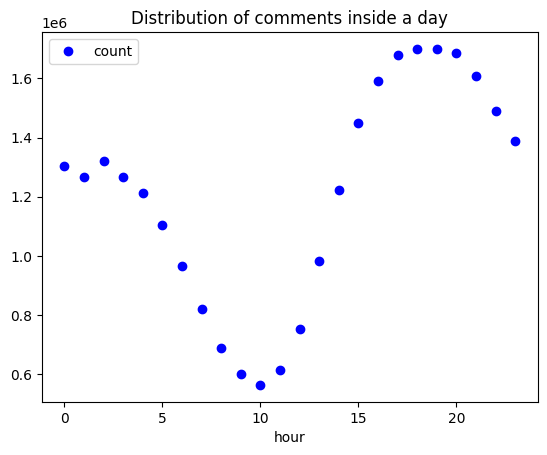

In [16]:
import pandas
## distribution of comments inside a day
df2=date.groupBy(f.hour("timestamp").alias("hour")).count()
d=df2.toPandas()
d.sort_values(by="hour")
d.plot(x="hour", y='count', style='bo', title="Distribution of comments inside a day" )

<Axes: title={'center': 'Trending per day (overall reddit post count)'}, xlabel='day'>

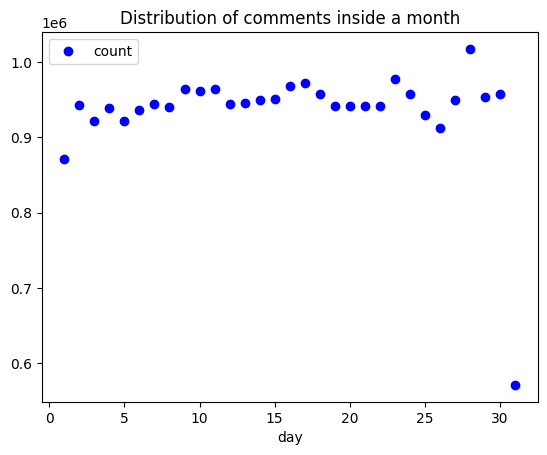

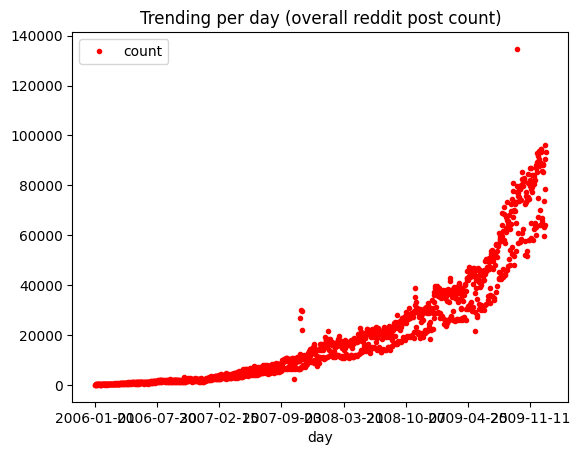

In [18]:
    #Procedur for periodic distribution and trending over time
    print("Give one of the following: \"hour\", \"day\", \"month\", \"year\"")
    name=input()
    while name not in ["hour", "day", "month", "year"]:
        clear_output(wait=False)
        print("Give one of the following: \"hour\", \"day\", \"month\", \"year\"")
        name=input()

    if name=="hour":
        func=f.hour
        form='yyyy-MM-dd HH'
        session='day'
        si=1
    elif name=="day":
        func=f.dayofmonth
        form='yyyy-MM-dd'
        session='month'
        si=3
    elif name=="month":
        func=f.month
        form='yyyy-MM'
        session='year'
        si=5
    elif name=="year":
        func=f.year
        form='yyyy'
        si=10

    ## distribution of comments inside a day
    clear_output(wait=False)
    df2=date.groupBy(func("timestamp").alias(name)).count()
    d=df2.toPandas()
    d.sort_values(by=name)
    d.plot(x=name, y='count', style='bo', title="Distribution of comments inside a "+session)

    ## Change over period (day) overall comments
    df2=date.select(f.date_format('timestamp',form).alias(name)).groupby(name).count()
    d=df2.toPandas()
    d=d.sort_values(by=name)
    d.plot(x=name, y='count', style='ro',ms=si, title="Trending per "+name +" (overall reddit post count)")

<Axes: title={'center': 'Trending per year\n Wordcount for the word: year'}, xlabel='year'>

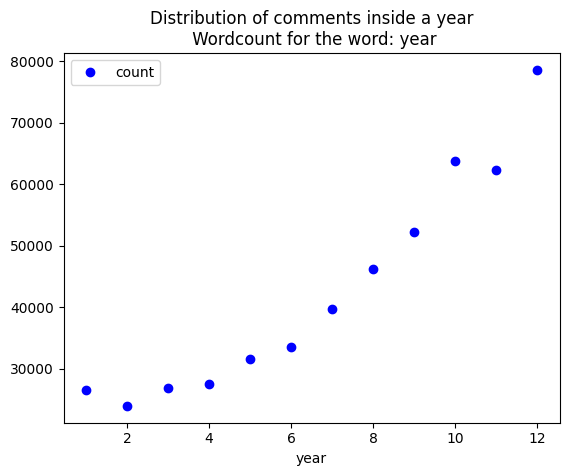

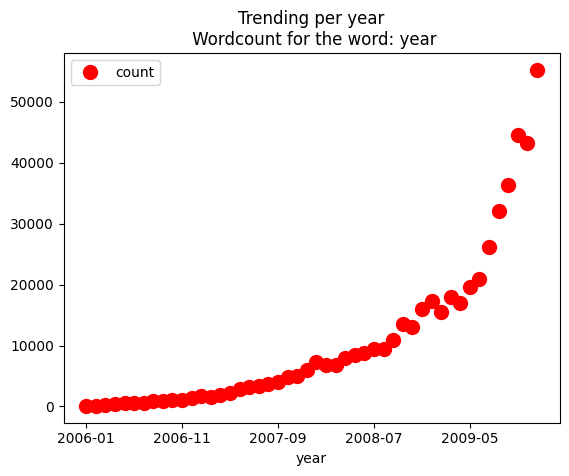

In [17]:
## Getting words separated, get rid of special characters and convert to lowercaese for analysis

df3=date.withColumn("body", f.regexp_replace(date.body, "[^a-zA-Z0-9]", " "));
raw_words=df3.withColumn('body',f.explode(f.split('body',' ')))
words = raw_words.withColumn('body', f.lower(f.trim(raw_words.body)))


#Read searched word and filter data for it
print("Give the searched key word:")
word=str.lower(input())
dff=words.filter(words.body==word)


#Same procedur for periodic distribution and trending over time
print("Give one of the following: \"hour\", \"day\", \"month\", \"year\"")
name=input()
while name not in ["hour", "day", "month", "year"]:
    clear_output(wait=False)
    print("Give one of the following: \"hour\", \"day\", \"month\", \"year\"")
    name=input()

    if name=="hour":
        func=f.hour
        form='yyyy-MM-dd HH'
        session='day'
        si=1
    elif name=="day":
        func=f.dayofmonth
        form='yyyy-MM-dd'
        session='month'
        si=3
    elif name=="month":
        func=f.month
        form='yyyy-MM'
        session='year'
        si=5
    elif name=="year":
        func=f.year
        form='yyyy'
        session="period of years"
        si=10
        
## distribution of comments inside a day
clear_output(wait=False)
df2=dff.groupBy(func("timestamp").alias(name)).count()
d=df2.toPandas()
d.sort_values(by=name)
d.plot(x=name, y='count', style='bo', title="Distribution of comments inside a "+session+"\n Wordcount for the word: "+word)

## Change over period (day) overall comments

df2=dff.select(f.date_format('timestamp',form).alias(name)).groupby(name).count()
d=df2.toPandas()
d=d.sort_values(by=name)
d.plot(x=name, y='count', style='ro', ms=si, title="Trending per "+name+"\n Wordcount for the word: "+word)

In [74]:
from pyspark.sql.window import Window

df5=df.groupBy(df.author).count()

win = Window.orderBy('count')

cdf=df5.withColumn('cumulative_probability', f.percent_rank().over(win)) \
    .withColumn('count', f.col("count")) \
    .groupBy("count")\
    .agg(f.max("cumulative_probability").alias("cumulative_probability"),f.count('*').alias("my_count")) \
    .withColumn("cumulative_probability", f.lead(f.col("cumulative_probability")).over(win)) \
    .fillna(1, subset=["cumulative_probability"])

win = Window.orderBy('my_count')
cdf3=cdf.withColumn('cumulative_probability', f.percent_rank().over(win)) \


cdf3.take(10)

23/03/19 22:51:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/19 22:51:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/19 22:51:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/19 22:51:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/19 22:51:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


[Row(count=4082, cumulative_probability=0.0, my_count=1),
 Row(count=2983, cumulative_probability=0.0, my_count=1),
 Row(count=1756, cumulative_probability=0.0, my_count=1),
 Row(count=1559, cumulative_probability=0.0, my_count=1),
 Row(count=1407, cumulative_probability=0.0, my_count=1),
 Row(count=4306, cumulative_probability=0.0, my_count=1),
 Row(count=1945, cumulative_probability=0.0, my_count=1),
 Row(count=2247, cumulative_probability=0.0, my_count=1),
 Row(count=2694, cumulative_probability=0.0, my_count=1),
 Row(count=5135, cumulative_probability=0.0, my_count=1)]

In [64]:
cdf2=df5.groupBy(df5['count'].alias('cnt')).count()

In [65]:
cdf2.printSchema()

root
 |-- cnt: long (nullable = false)
 |-- count: long (nullable = false)



In [35]:
d=cdf.toPandas()

In [50]:
d2=cdf.toPandas()

23/03/19 22:26:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/19 22:26:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/19 22:26:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/19 22:27:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/19 22:27:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/19 22:27:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/19 2

<Axes: title={'center': 'loglog plot of user-posts'}, xlabel='cumulative_probability_pop'>

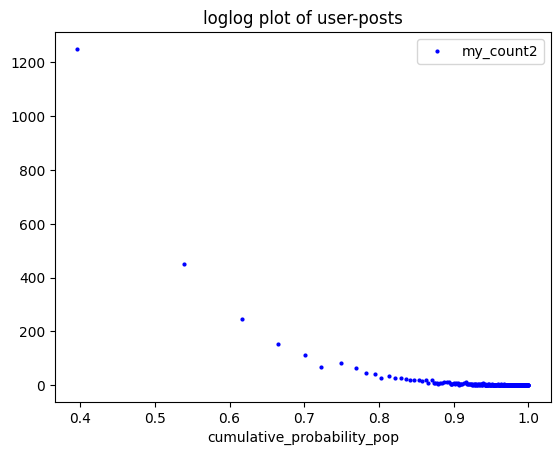

In [53]:
d2.plot(x='cumulative_probability_pop', y='my_count2', style='bo', ms=2, title="loglog plot of user-posts")

<Axes: title={'center': 'loglog plot of user-posts'}, xlabel='count'>

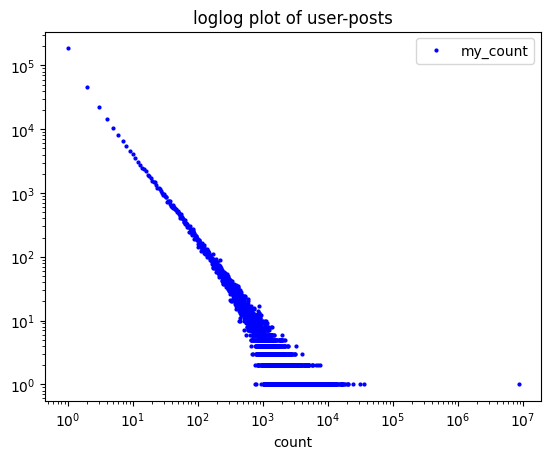

In [43]:
d.plot(x='count', y='my_count', style='bo', ms=2, loglog=True, title="loglog plot of user-posts")

In [14]:
spark_session.stop()